## About this project

This is the first stage in a project for performing music genre classification using a Convolutional Neural Network. In order to do this, the GTZAN dataset will be used to predict the genre of songs. The GTZAN dataset contains many 30 second .wav files that are song clips categorized into folders by genre. In order to use it as input to a Convolutional Neural Network, the .wav files need to be pre-processed and a .json file will be created containing the input information for each song. This Jupyter Notebook will contain the pre-processing stage as well as some explanatory information about Mel-Frequency Cepstral Coefficients (MFCCs), which will be the primary input to the Convolutional Neural Network.

For the task of genre classification, MFCC's will be extracted from the GTZAN .wav files and treated the same way as image data, used as inputs to a Convolutional Neural Network. The label of genre is found from the organization of the GTZAN dataset into folders by genre, and will be captured along with the MFCCs in a .json file. Because the .json file only needs to be built once, and it is a time consuming operation, this task will be performed in this notebook, and the Convolutional Neural Network will be built in a subsequent notebook.

## Acknowledgements

This project is created by following along with the tutorials from the Youtube series "Deep Learning (for Audio) with Python" by creator Velerio Velardo - The Sound of AI: https://www.youtube.com/playlist?list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf

The GTZAN dataset can be found here: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

Note: Due to an error with file .../genres_original/jazz/jazz00054.wav in the original GTZAN dataset, this project uses a modified copy of the genres folder which excludes this file. This modified folder is named genres and is identical to the GTZAN genres_original folder with the exception of this file.

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

import math
import json
import librosa, librosa.display

## Visual Demo and Explanation of Audio Data & MFCCs

Mel-Frequency Cepstral Coefficients (MFCCs), are coefficients representing the short-term power spectrum of a sound signal and are commonly used in speech and audio processing. MFCCs provide a compact representation of the spectral properties of a sound signal in a way that captures timbre, while focusing on the aspects that are perceptually relevant to humans. Timbre is the quality of a sound that differentiates it from other sounds with the same pitch and loudness and includes harmonic content, overtones and resonances, and attack and decay. Due to these properties of MFCCs, they are a very useful input for machine-learning tasks.

At a high level, MFCCs are calculated with the following steps:
- Perform a short time fourier transform (STFT) on the signal
- Apply the Mel Filterbank, which approximates the human ear's frequency perception
- Compute the logrithm of the Mel-filtered spectrum to reflect the logrithmic nature of human hearing
- Apply the Discrete Cosine Transform (DCT) to produce the MFCCs, which are a compact representation of the spectral features

To demonstate what MFCC's and the transformation of audio data in the stages used to calculate MFCCs look like as images, various plots will be shown for one song.

#### Load Demo .wav File and Display Waveplot

Note: Sample rate (sr) is # of samples per second. Signal is an array of length (sr * seconds). Each value in the signal array represents the audio sample's amplitude at a given point in time.

<function matplotlib.pyplot.show(close=None, block=None)>

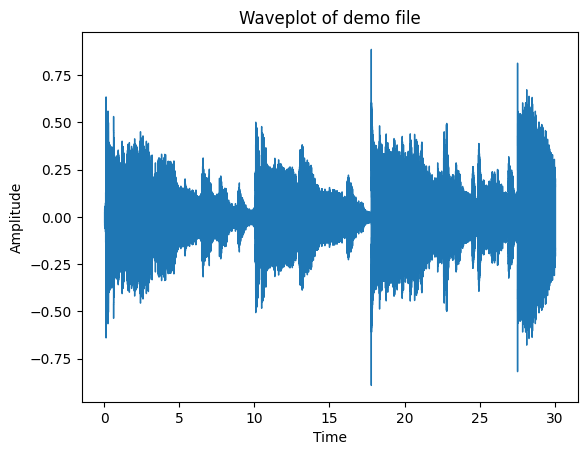

In [2]:
demo_filename = os.path.join(os.getcwd(), "data", "genres", "jazz", "jazz.00002.wav")

# Load the signal and sample rate (sr)
signal, sr = librosa.load(demo_filename, sr=22050)

# Display the waveform of the .wav file
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveplot of demo file")
plt.show

#### Display Fast-Fourier Transform spectrum
The Fast Fourier Transform (FFT) is used to measure how much each frequency contributes to the overall sound.

<function matplotlib.pyplot.show(close=None, block=None)>

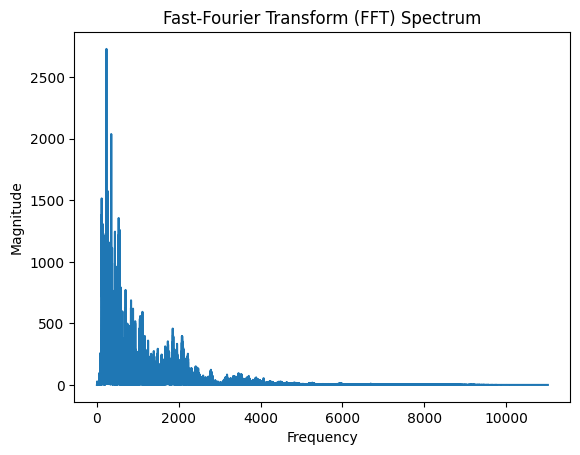

In [3]:
#Perform fast fourier transform
fft = np.fft.fft(signal)

# Get magnitude
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_magnitude = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Fast-Fourier Transform (FFT) Spectrum")
plt.show

#### Display Spectrogram Using Short Time Fourier Transform (STFT)
The Fast-Fourier Transform (FFT) does not capture time information. The Short-Time Fourier Transform (STFT) incorporates the element of time to capture the frequency magnitudes over time.

<function matplotlib.pyplot.show(close=None, block=None)>

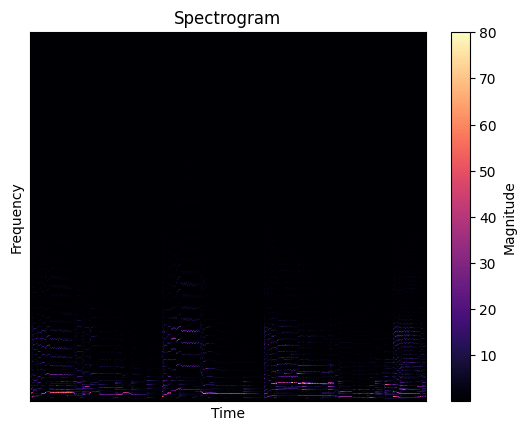

In [4]:
n_fft = 2048 # number of samples per fft
hop_length = 512 # amount of shift to the right after each fft

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

spectrogram = np.abs(stft)

librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Spectrogram")
cbar = plt.colorbar()
cbar.set_label("Magnitude")
plt.show

#### Display Logrithmic Spectrogram
The spectrogram created from the STFT shows frequency in a linear way. However, humans perceive frequency in a logrithmic way. Below, a spectrogram shows frequency using a logrithmic scale.

<function matplotlib.pyplot.show(close=None, block=None)>

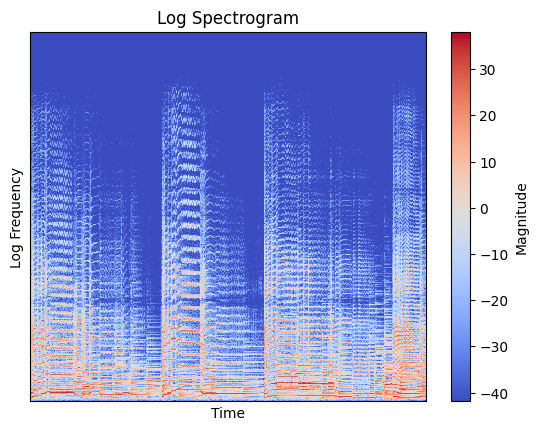

In [5]:
log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Log Frequency")
plt.title("Log Spectrogram")
cbar = plt.colorbar()
cbar.set_label("Magnitude")
plt.show

#### Display MFCCs (Mel-Frequency Cepstral Coefficients).

<function matplotlib.pyplot.show(close=None, block=None)>

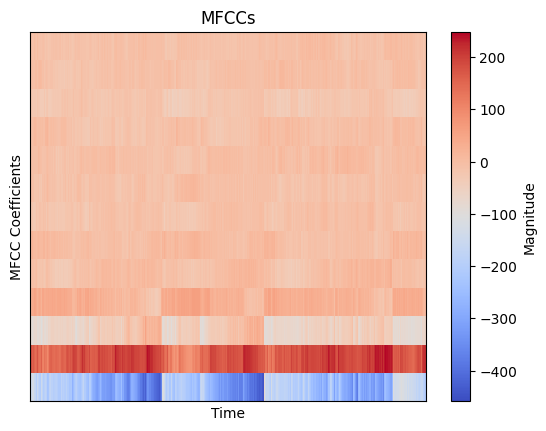

In [6]:
MFCCs = librosa.feature.mfcc(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.title("MFCCs")
cbar = plt.colorbar()
cbar.set_label("Magnitude")
plt.show

## Prepare the Dataset

Now it is time to prepare the dataset so that it can be used as the input to a Convolutional Neural Network. Consider the above plot of the MFCCs for the demo song as an image. For each song, this MFCC information will be generated and paired with the song's label and label mapping information. Mapping will contain the semantic/string version of the genre and labels will contain a numeric value that is correlated to each genre. The MFCC information will be treated the same way an image would be treated and will be used as the input to a Convolutional Neural Network, which will be built in a subsequent notebook.

To create more data, each song will be broken into multiple segments and MFCCs will be calculated for each segment.

Here is a brief overview of the process:
- Create empty dictionary which will be used to hold semantic labels aka a string for each genre ("mapping" key), numerical labels corresponding to each genre for each audio segment ("label" key), and mfccs for each audio segment ("mfcc" key).
- Loop through all the genre folders. For each genre, add a string of the genre to the values list that corresponds to the "mapping" key.
- Within each genre folder, loop through the .wav files.
- For each .wav file, break the song into multiple segments. Ten segments is the number chosen for this project. This is done to create more data.
- Calculate MFCCs for each segment. In this case, there are 130 MFCC vectors per segment (this is determined by the number of samples per segment divided by the hop-length). Each MFCC vector within each segment contains 13 coefficients (this is determined by the parameter n_mfcc). This creates a 130 x 13 2d array for each segment.
- Append the MFCC array to the list of values corresponding to the "mfcc" dictionary key
- Append a numerical representation of the label to the list of values corresponding to the "label" dictionary key.
- Exit all of the above loops and dump the dictionary into a .json file.

Note: The below cell may take a while to run.

In [7]:
DATASET_PATH = os.path.join("data", "genres")
JSON_PATH = os.path.join("data", "data.json")

SAMPLE_RATE = 22050
DURATION = 30 # measures in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    # dictionary to store data
    data = {
        "mapping" : [],
        "mfcc" : [],
        "labels" : []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure that we're not at root level
        if dirpath is not dataset_path:

            # save the semantic label
            dirpath_components = dirpath.split("/") # genre/blues => ['genre', 'blues']
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for f in filenames:

                # Skip non-audio files
                if not f.endswith(".wav"):
                    continue
                    
                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                # process segments extracting mfcc and storing data
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample], sr=sr, n_fft=n_fft, n_mfcc=n_mfcc, hop_length=hop_length)

                    mfcc = mfcc.T

                    # store mfcc for segment if it has the expected length
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, s+1))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing pop
data/genres/pop/pop.00027.wav, segment:1
data/genres/pop/pop.00027.wav, segment:2
data/genres/pop/pop.00027.wav, segment:3
data/genres/pop/pop.00027.wav, segment:4
data/genres/pop/pop.00027.wav, segment:5
data/genres/pop/pop.00027.wav, segment:6
data/genres/pop/pop.00027.wav, segment:7
data/genres/pop/pop.00027.wav, segment:8
data/genres/pop/pop.00027.wav, segment:9
data/genres/pop/pop.00027.wav, segment:10
data/genres/pop/pop.00033.wav, segment:1
data/genres/pop/pop.00033.wav, segment:2
data/genres/pop/pop.00033.wav, segment:3
data/genres/pop/pop.00033.wav, segment:4
data/genres/pop/pop.00033.wav, segment:5
data/genres/pop/pop.00033.wav, segment:6
data/genres/pop/pop.00033.wav, segment:7
data/genres/pop/pop.00033.wav, segment:8
data/genres/pop/pop.00033.wav, segment:9
data/genres/pop/pop.00033.wav, segment:10
data/genres/pop/pop.00032.wav, segment:1
data/genres/pop/pop.00032.wav, segment:2
data/genres/pop/pop.00032.wav, segment:3
data/genres/pop/pop.00032.wav, segment: